In [70]:
#Notebook for Crime and Weather Data Wrangling
#ASSUMPTIONS
#We are only using 2016 date
#For weather we consider below fields:
  #Temperature
  #Pressure
  #Humidity
  #Wind
  #Precipitation
  #Clouds
#We are only focusing on top crime


#SEPARATE for crime count vs weather Carlos, Doris
#1. Agregate data based on crime count -> Larceny-from vehicle
#2. Agregate by date
#3. Get weather data per date
#4. Test correlations

#SEPARATE for crime count vs ice-cream shop Rabia, Isaiah 
#1. Agregate data based on crime count -> Larceny-from vehicle
#2. Agregate by date to get crime count ->5
#2. Add number of shops per coordinate per date -> take max count
#3. Correlate crime count vs number of shops

#VISUALIZATIONS & HYPOTHESIS TESTING FOR CRIME vs WEATHER
#location map of of count of crimes in Atlanta (put in the first part)
#pie chart of all types of crimes
#bar plot of LARCENY-FROM VEHICLE	 count per month in 2016
#ditplot of crime count
#distplot of max temps & each weather variable (pressure,humidity, wind, precipitation, cloud)
#scatter plot of crime count per date vs temperature
#scatter plot of crime count per date vs each weather variable (pressure,humidity, wind, precipitation, cloud)

#VISUALIZATIONS & HYPOTHESIS TESTING FOR CRIME vs ICE-CREAM
#distplot of ice-crem shop count
#scatter plot of crime count per date vs ice-cream shop count
#gplot of crime with max temp and ice-cream shop vcicnity (pick one row)

#CONCLUSION & OBSERVATIONS
#Result of testing hypothesis
#fun facts!

# Section 1: Import Libraries

In [71]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import os
import gmaps
import scipy.stats as sts
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

#Google developer API key {Carlos}
from config import gkey
#Visual Crossing key- Historical Weather {Carlos} https://www.visualcrossing.com/
from config import vcwkey

%matplotlib inline

# Section 2: Load Dataset

In [72]:
#Load Atlanta Crime Dataset taken from: https://data.world/bryantahb/crime-in-atlanta-2009-2017
path = os.path.join('..','Resources','atlcrime.csv')
df = pd.read_csv(path)
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,crime,number,date,location,beat,neighborhood,npu,lat,long
0,LARCENY-NON VEHICLE,103040029,10/31/2010,610 SPRING ST NW,509,Downtown,M,33.77101,-84.38895
1,AUTO THEFT,103040061,10/31/2010,850 OAK ST SW,401,West End,T,33.74057,-84.41680
2,LARCENY-FROM VEHICLE,103040169,10/31/2010,1344 METROPOLITAN PKWY SW,301,Capitol View Manor,X,33.71803,-84.40774
3,AUTO THEFT,103040174,10/31/2010,1752 PRYOR RD SW,307,Betmar LaVilla,Y,33.70731,-84.39674
4,LARCENY-NON VEHICLE,103040301,10/31/2010,JOHN WESLEY DOBBS AVE NE / CORLEY ST NE,604,Old Fourth Ward,M,33.75947,-84.36626


In [73]:
#Explore the Dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270688 entries, 0 to 270687
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   crime         270688 non-null  object 
 1   number        270688 non-null  int64  
 2   date          270688 non-null  object 
 3   location      270686 non-null  object 
 4   beat          270688 non-null  object 
 5   neighborhood  258928 non-null  object 
 6   npu           268592 non-null  object 
 7   lat           270688 non-null  float64
 8   long          270688 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 18.6+ MB


In [74]:
df.describe()

,number,lat,long
count,2.706880e+05,270688.000000,270688.000000
mean,4.705194e+08,33.755246,-84.408178
std,6.768886e+09,0.045540,0.047298
min,7.269234e+07,33.460100,-84.550500
25%,1.029113e+08,33.727780,-84.433880
50%,1.227606e+08,33.755380,-84.397520
75%,1.432412e+08,33.780140,-84.374090
max,1.704427e+11,33.886130,-84.286410


In [75]:
#Split Date column into day, month, and year to be able to call Visual Crossing API
dsplit = df['date'].apply(lambda x: x.split("/"))
months = []
days = []
years = []

for item in dsplit:
    months.append(item[0])
    days.append(item[1])
    years.append(item[2])

#Create Month, Day and Year columns
df['Month'] = months
df['Day'] = days
df['Year'] = years

df.head()

,crime,number,date,location,beat,neighborhood,npu,lat,long,Month,Day,Year
0,LARCENY-NON VEHICLE,103040029,10/31/2010,610 SPRING ST NW,509,Downtown,M,33.77101,-84.38895,10,31,2010
1,AUTO THEFT,103040061,10/31/2010,850 OAK ST SW,401,West End,T,33.74057,-84.41680,10,31,2010
2,LARCENY-FROM VEHICLE,103040169,10/31/2010,1344 METROPOLITAN PKWY SW,301,Capitol View Manor,X,33.71803,-84.40774,10,31,2010
3,AUTO THEFT,103040174,10/31/2010,1752 PRYOR RD SW,307,Betmar LaVilla,Y,33.70731,-84.39674,10,31,2010
4,LARCENY-NON VEHICLE,103040301,10/31/2010,JOHN WESLEY DOBBS AVE NE / CORLEY ST NE,604,Old Fourth Ward,M,33.75947,-84.36626,10,31,2010


In [76]:
#We will only focus on crime happenning in year 2016
crime = df.loc[df['Year']=='2016']
crime.reset_index(drop =True, inplace=True)
crime.head()

,crime,number,date,location,beat,neighborhood,npu,lat,long,Month,Day,Year
0,HOMICIDE,163051391092,10/31/2016,1205 METROPOLITAN AVE SE,612,East Atlanta,W,33.74173,-84.34749,10,31,2016
1,AUTO THEFT,163030548,10/31/2016,180 PONCE DE LEON AVE NE,505,Midtown,E,33.77285,-84.38149,10,31,2016
2,LARCENY-FROM VEHICLE,163041611,10/31/2016,1783 JOHNSON RD NW,110,Rockdale,G,33.78547,-84.44593,10,31,2016
3,LARCENY-FROM VEHICLE,163050183,10/31/2016,1000 NORTHSIDE DR NW,501,Home Park,E,33.78196,-84.40835,10,31,2016
4,AUTO THEFT,163050218,10/31/2016,2264 COUNTRY CLUB DR SW,409,Southwest,R,33.69384,-84.49398,10,31,2016


# Section 3: Create Groups by Crime Type

In [77]:
#We will pick as our groups 5 unrelated types of crime
#1. LARCENY-FROM VEHICLE
#2. BURGLARY-RESIDENCE
#3. ROBBERY-PEDESTRIAN
#4. RAPE
#5. HOMICIDE
crime['crime'].value_counts()

LARCENY-FROM VEHICLE    9980
LARCENY-NON VEHICLE     6616
AUTO THEFT              3832
BURGLARY-RESIDENCE      3409
AGG ASSAULT             2170
ROBBERY-PEDESTRIAN      1501
BURGLARY-NONRES          968
ROBBERY-RESIDENCE        205
ROBBERY-COMMERCIAL       201
RAPE                     142
HOMICIDE                 107
Name: crime, dtype: int64

In [78]:
#Group 1: LARCENY-FROM VEHICLE
g1 = crime.loc[crime['crime']=='LARCENY-FROM VEHICLE']
g1.reset_index(drop =True, inplace=True)
g1.drop(['number', 'date', 'location', 'beat', 'neighborhood', 'npu',
       'lat', 'long','Year'], axis=1, inplace=True)
g1w = g1.groupby(['Month','Day']).count()
g1w.rename(columns={'crime':'Crime Count'},inplace=True)
g1w.reset_index(inplace=True)

#Group 2: BURGLARY-RESIDENCE
g2 = crime.loc[crime['crime']=='BURGLARY-RESIDENCE']
g2.reset_index(drop =True, inplace=True)
g2.drop(['number', 'date', 'location', 'beat', 'neighborhood', 'npu',
       'lat', 'long','Year'], axis=1, inplace=True)
g2w = g2.groupby(['Month','Day']).count()
g2w.rename(columns={'crime':'Crime Count'},inplace=True)
g2w.reset_index(inplace=True)

#Group 3: ROBBERY-PEDESTRIAN
g3 = crime.loc[crime['crime']=='ROBBERY-PEDESTRIAN']
g3.reset_index(drop =True, inplace=True)
g3.drop(['number', 'date', 'location', 'beat', 'neighborhood', 'npu',
       'lat', 'long','Year'], axis=1, inplace=True)
g3w = g3.groupby(['Month','Day']).count()
g3w.rename(columns={'crime':'Crime Count'},inplace=True)
g3w.reset_index(inplace=True)

#Group 4: RAPE
g4 = crime.loc[crime['crime']=='RAPE']
g4.reset_index(drop =True, inplace=True)
g4.drop(['number', 'date', 'location', 'beat', 'neighborhood', 'npu',
       'lat', 'long','Year'], axis=1, inplace=True)
g4w = g4.groupby(['Month','Day']).count()
g4w.rename(columns={'crime':'Crime Count'},inplace=True)
g4w.reset_index(inplace=True)

#Group 5: HOMICIDE
g5 = crime.loc[crime['crime']=='HOMICIDE']
g5.reset_index(drop =True, inplace=True)
g5.drop(['number', 'date', 'location', 'beat', 'neighborhood', 'npu',
       'lat', 'long','Year'], axis=1, inplace=True)
g5w = g5.groupby(['Month','Day']).count()
g5w.rename(columns={'crime':'Crime Count'},inplace=True)
g5w.reset_index(inplace=True)

In [79]:
#Visualization of Crime Groups aggregated by Date (Month & Day)
g1w

,Month,Day,Crime Count
0,01,01,21
1,01,02,28
2,01,03,24
3,01,04,29
4,01,05,27
...,...,...,...
361,12,27,22
362,12,28,30
363,12,29,26
364,12,30,23


# Section 4: Visual Crossing Weather API

In [80]:
#Create Needed Columns for all 5 Groups

#Group 1: LARCENY-FROM VEHICLE
g1w['Avg_Temp']=''
g1w['Humidity']=''
g1w['Precip']=''
g1w['Wind_Speed']=''
g1w['Conditions']=''

#Group 2: BURGLARY-RESIDENCE
g2w['Avg_Temp']=''
g2w['Humidity']=''
g2w['Precip']=''
g2w['Wind_Speed']=''
g2w['Conditions']=''

#Group 3: ROBBERY-PEDESTRIAN
g3w['Avg_Temp']=''
g3w['Humidity']=''
g3w['Precip']=''
g3w['Wind_Speed']=''
g3w['Conditions']=''

#Group 4: RAPE
g4w['Avg_Temp']=''
g4w['Humidity']=''
g4w['Precip']=''
g4w['Wind_Speed']=''
g4w['Conditions']=''

#Group 5: HOMICIDE
g5w['Avg_Temp']=''
g5w['Humidity']=''
g5w['Precip']=''
g5w['Wind_Speed']=''
g5w['Conditions']=''

#Perform API call to get historical weather for year 2016 in Atlanta based on Month and Day
base_url = 'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/weatherdata/history'
location = 'Atlanta'
aggregateHours = '24'
unitGroup = 'us'
contentType = 'json'

#Parameter for the API call, units will be handled in Metric system
params = {'key':vcwkey, 'location':location, 'aggregateHours':aggregateHours,
          'unitGroup':unitGroup,'contentType':contentType}
#**************************************************************************************************************
#Group 1: LARCENY-FROM VEHICLE

for i, row in g1w.iterrows():
    params['startDateTime'] = '2016-'+row['Month']+'-'+row['Day']+'T00:00:00'
    params['endDateTime'] = '2016-'+row['Month']+'-'+row['Day']+'T23:00:00'
    response = requests.get(base_url,params=params).json()
    
    try:
        g1w.loc[i,'Avg_Temp']= response['locations']['Atlanta']['values'][0]['temp']
        g1w.loc[i,'Humidity']= response['locations']['Atlanta']['values'][0]['humidity']
        g1w.loc[i,'Precip']= response['locations']['Atlanta']['values'][0]['precip']
        g1w.loc[i,'Wind_Speed']= response['locations']['Atlanta']['values'][0]['wspd']
        g1w.loc[i,'Conditions']= response['locations']['Atlanta']['values'][0]['conditions']
    except:
        g1w.loc[i,['Avg_Temp','Humidity','Precip','Wind_Speed','Conditions']] = np.nan
        
#**************************************************************************************************************
#Group 2: BURGLARY-RESIDENCE

for i, row in g2w.iterrows():
    params['startDateTime'] = '2016-'+row['Month']+'-'+row['Day']+'T00:00:00'
    params['endDateTime'] = '2016-'+row['Month']+'-'+row['Day']+'T23:00:00'
    response = requests.get(base_url,params=params).json()
    
    try:
        g2w.loc[i,'Avg_Temp']= response['locations']['Atlanta']['values'][0]['temp']
        g2w.loc[i,'Humidity']= response['locations']['Atlanta']['values'][0]['humidity']
        g2w.loc[i,'Precip']= response['locations']['Atlanta']['values'][0]['precip']
        g2w.loc[i,'Wind_Speed']= response['locations']['Atlanta']['values'][0]['wspd']
        g2w.loc[i,'Conditions']= response['locations']['Atlanta']['values'][0]['conditions']
    except:
        g2w.loc[i,['Avg_Temp','Humidity','Precip','Wind_Speed','Conditions']] = np.nan    
 
#**************************************************************************************************************
#Group 3: ROBBERY-PEDESTRIAN

for i, row in g3w.iterrows():
    params['startDateTime'] = '2016-'+row['Month']+'-'+row['Day']+'T00:00:00'
    params['endDateTime'] = '2016-'+row['Month']+'-'+row['Day']+'T23:00:00'
    response = requests.get(base_url,params=params).json()
    
    try:
        g3w.loc[i,'Avg_Temp']= response['locations']['Atlanta']['values'][0]['temp']
        g3w.loc[i,'Humidity']= response['locations']['Atlanta']['values'][0]['humidity']
        g3w.loc[i,'Precip']= response['locations']['Atlanta']['values'][0]['precip']
        g3w.loc[i,'Wind_Speed']= response['locations']['Atlanta']['values'][0]['wspd']
        g3w.loc[i,'Conditions']= response['locations']['Atlanta']['values'][0]['conditions']
    except:
        g3w.loc[i,['Avg_Temp','Humidity','Precip','Wind_Speed','Conditions']] = np.nan
        
#**************************************************************************************************************
#Group 4: RAPE

for i, row in g4w.iterrows():
    params['startDateTime'] = '2016-'+row['Month']+'-'+row['Day']+'T00:00:00'
    params['endDateTime'] = '2016-'+row['Month']+'-'+row['Day']+'T23:00:00'
    response = requests.get(base_url,params=params).json()
    
    try:
        g4w.loc[i,'Avg_Temp']= response['locations']['Atlanta']['values'][0]['temp']
        g4w.loc[i,'Humidity']= response['locations']['Atlanta']['values'][0]['humidity']
        g4w.loc[i,'Precip']= response['locations']['Atlanta']['values'][0]['precip']
        g4w.loc[i,'Wind_Speed']= response['locations']['Atlanta']['values'][0]['wspd']
        g4w.loc[i,'Conditions']= response['locations']['Atlanta']['values'][0]['conditions']
    except:
        g4w.loc[i,['Avg_Temp','Humidity','Precip','Wind_Speed','Conditions']] = np.nan
        
#**************************************************************************************************************
#Group 5: HOMICIDE

for i, row in g5w.iterrows():
    params['startDateTime'] = '2016-'+row['Month']+'-'+row['Day']+'T00:00:00'
    params['endDateTime'] = '2016-'+row['Month']+'-'+row['Day']+'T23:00:00'
    response = requests.get(base_url,params=params).json()
    
    try:
        g5w.loc[i,'Avg_Temp']= response['locations']['Atlanta']['values'][0]['temp']
        g5w.loc[i,'Humidity']= response['locations']['Atlanta']['values'][0]['humidity']
        g5w.loc[i,'Precip']= response['locations']['Atlanta']['values'][0]['precip']
        g5w.loc[i,'Wind_Speed']= response['locations']['Atlanta']['values'][0]['wspd']
        g5w.loc[i,'Conditions']= response['locations']['Atlanta']['values'][0]['conditions']
    except:
        g5w.loc[i,['Avg_Temp','Humidity','Precip','Wind_Speed','Conditions']] = np.nan

In [81]:
#Visualize Completed Dataframes
g1w

,Month,Day,Crime Count,Avg_Temp,Humidity,Precip,Wind_Speed,Conditions
0,01,01,21,42.8,67.84,0,13.3,Partially cloudy
1,01,02,28,40,58.12,0,13.8,Partially cloudy
2,01,03,24,42.2,54.95,0,12.7,Partially cloudy
3,01,04,29,38.5,53.05,0,16.7,Clear
4,01,05,27,34.6,44.61,0,12.6,Clear
...,...,...,...,...,...,...,...,...
361,12,27,22,62.2,86.62,0.01,12.6,"Rain, Overcast"
362,12,28,30,55.9,67.24,0,7.5,Partially cloudy
363,12,29,26,56.4,54.45,0.68,26,"Rain, Partially cloudy"
364,12,30,23,42.5,36,0,16.1,Clear


# Section5: Save Dataframes

In [82]:
# Save DataFrames as csv for tem meambers to use
g1w.to_csv('../Resources/larceny.csv')
g2w.to_csv('../Resources/burglary.csv')
g3w.to_csv('../Resources/robbery.csv')
g4w.to_csv('../Resources/rape.csv')
g5w.to_csv('../Resources/homicide.csv')
crime.to_csv('../Resources/ATLCrime2016.csv')

In [83]:

g1w['Avg_Temp'] = g1w['Avg_Temp'].astype(float)
g1w['Humidity'] = g1w['Humidity'].astype(float)
g1w['Precip'] = g1w['Precip'].astype(float)
g1w['Wind_Speed'] = g1w['Wind_Speed'].astype(float)
g1w.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Month        366 non-null    object 
 1   Day          366 non-null    object 
 2   Crime Count  366 non-null    int64  
 3   Avg_Temp     366 non-null    float64
 4   Humidity     366 non-null    float64
 5   Precip       366 non-null    float64
 6   Wind_Speed   366 non-null    float64
 7   Conditions   366 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 23.0+ KB


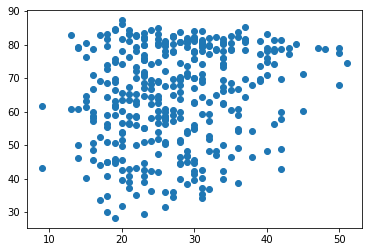

In [84]:
plt.scatter(g1w['Crime Count'],g1w['Avg_Temp'])

In [85]:
sts.pearsonr(g1w['Crime Count'],g1w['Wind_Speed'])

(-0.12476937685579438, 0.016933306265737573)

In [86]:
#Create Gmap of Crime in Atlanta in 2016 for a summer month for Top Crime Type


#Configure Gmaps
gmaps.configure(api_key=gkey)

#Load parameters
coordg1 = crime.loc[(crime['crime']=='ROBBERY-PEDESTRIAN') & (crime['Month']=='06')][['lat','long']]
#coordg2 = g2.loc[g2['Month']=='06'][['lat','long']]

figure_layout = {
    
    'width':'1000px',
    'height':'600px',
    'border':'1px solid black',
    'padding':'1px',
    'margin':'0 auto 0 auto'
}

f = gmaps.figure(layout=figure_layout)
f.add_layer(gmaps.symbol_layer(coordg1, fill_color='red', stroke_color='red', scale=2))
#f.add_layer(gmaps.symbol_layer(coordg2, fill_color='green', stroke_color='green', scale=2))
f

Figure(layout=FigureLayout(border='1px solid black', height='600px', margin='0 auto 0 auto', padding='1px', wi…

In [87]:
crime

,crime,number,date,location,beat,neighborhood,npu,lat,long,Month,Day,Year
0,HOMICIDE,163051391092,10/31/2016,1205 METROPOLITAN AVE SE,612,East Atlanta,W,33.74173,-84.34749,10,31,2016
1,AUTO THEFT,163030548,10/31/2016,180 PONCE DE LEON AVE NE,505,Midtown,E,33.77285,-84.38149,10,31,2016
2,LARCENY-FROM VEHICLE,163041611,10/31/2016,1783 JOHNSON RD NW,110,Rockdale,G,33.78547,-84.44593,10,31,2016
3,LARCENY-FROM VEHICLE,163050183,10/31/2016,1000 NORTHSIDE DR NW,501,Home Park,E,33.78196,-84.40835,10,31,2016
4,AUTO THEFT,163050218,10/31/2016,2264 COUNTRY CLUB DR SW,409,Southwest,R,33.69384,-84.49398,10,31,2016
...,...,...,...,...,...,...,...,...,...,...,...,...
29126,BURGLARY-RESIDENCE,162391167,09/01/2016,834 LULLWATER RD NE,608,Druid Hills,N,33.77741,-84.33535,09,01,2016
29127,LARCENY-NON VEHICLE,162420896,09/01/2016,319 MCDONOUGH BLVD SE,307,Chosewood Park,Y,33.71664,-84.37816,09,01,2016
29128,LARCENY-FROM VEHICLE,162430003,09/01/2016,1950 CHILDRESS DR SW,407,Tuxedo Park,A,33.85844,-84.39221,09,01,2016
29129,LARCENY-FROM VEHICLE,162450076,09/01/2016,855 PEACHTREE STREET NE,505,Midtown,E,33.77800,-84.38424,09,01,2016


In [88]:
crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29131 entries, 0 to 29130
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   crime         29131 non-null  object 
 1   number        29131 non-null  int64  
 2   date          29131 non-null  object 
 3   location      29131 non-null  object 
 4   beat          29131 non-null  object 
 5   neighborhood  27795 non-null  object 
 6   npu           28877 non-null  object 
 7   lat           29131 non-null  float64
 8   long          29131 non-null  float64
 9   Month         29131 non-null  object 
 10  Day           29131 non-null  object 
 11  Year          29131 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 2.7+ MB
